# Neural integration for constitutive equations 

### Benchmark #2: porous, elasto-plastic material

Authors: Filippo Masi, Itai Einav

### 1. Import libraries

In [1]:
import pickle
import numpy as np
import torch
from scipy.optimize import root
from torchdiffeq import odeint
from nice_module import NICE, EarlyStopping, shuffle, slice_data, GetParams

np.random.seed(6)
torch.manual_seed(6)

# plotting
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('classic')
plt.rcParams.update({"axes.grid" : False, "grid.color": 'black', "grid.alpha":0.4})
font = {'size'   : 11}
matplotlib.rc('font', **font)
plt.rcParams['axes.facecolor']='none'
plt.rcParams['savefig.facecolor']='none'
plt.rcParams['figure.facecolor']='none'
plt.rcParams["figure.figsize"] = (2.5,2)
plt.tight_layout(pad=2.5, w_pad=3.5, h_pad=3.5)
colorb = (0.2,0.4,0.7)

<Figure size 200x160 with 0 Axes>

#### 1.1 Set hyperparameters

In [2]:
verbose_frequency = 10 # frequency in epochs for printing loss at training
step_size = 1 # to reproduce training process set = 20, else 1 (for fast training)
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')
corrupted_training_data = False # boolean for adding normally distributed noise to training data set
delta = 0. # if corrupted_training_data = True, set noise amplitude (percentage)

### 2. Import and prepare data sets

In [3]:
file = './dataset/benchmark2_data_training'
with open(file, 'rb') as f_obj:
    data = pickle.load(f_obj)

strain_t,strain_tdt,r_t,r_tdt,z_t,z_tdt,stress_t,dt,n_reset = data
batch_time = n_reset
data_size = n_reset
dim = 2
prm_dt = 1/data_size

#### 3.1 Reshape 


In [5]:
dstrain = strain_tdt - strain_t
dr = r_tdt - r_t
dz = z_tdt - z_t
dstrain/=prm_dt
dr/=prm_dt
dz/=prm_dt

strain_t = np.reshape(strain_t,(batch_time,-1,dim),order='F')
strain_tdt = np.reshape(strain_tdt,(batch_time,-1,dim),order='F')
dstrain = np.reshape(dstrain,(batch_time,-1,dim),order='F')
r_t = np.reshape(r_t,(batch_time,-1,1),order='F')
dr = np.reshape(dr,(batch_time,-1,1),order='F')
z_t = np.reshape(z_t,(batch_time,-1,1),order='F')
dz = np.reshape(dz,(batch_time,-1,1),order='F')
stress_t = np.reshape(stress_t,(batch_time,-1,dim),order='F')

data_size = strain_t.shape[0]
number_IC = strain_t.shape[1]

#### 3.2 Split data in training, validation, and test sets 

In [6]:
train_percentage = .65

train = int(round(number_IC * train_percentage))
val = int(round(number_IC * 0.5 *(1.- train_percentage)))
test = val

print("Number of samples: ", number_IC)
print("Training samples : ", train)
print("Validation samples : ", val)
print("Test samples : ", test)
print("Total : ", test + val + train)

Number of samples:  52
Training samples :  34
Validation samples :  9
Test samples :  9
Total :  52


In [7]:
n = np.arange(0,number_IC,1)
rnd = np.arange(len(n))
np.random.shuffle(rnd[:-4])
n = n[rnd]

ntrain = n[:train-4]
ntrain = np.hstack((ntrain,n[-4:]))
cut = len(ntrain)
nval = n[train:train+val]
ntrainval = np.hstack((ntrain,nval))
ntest = n[train+val:]


rnd = np.arange(len(ntrainval))
ntrain = rnd[:train]
nval = rnd[val:]

In [8]:
strain_t_tv,strain_t_test = slice_data(strain_t,ntrainval,ntest)
dstrain_tv,dstrain_test = slice_data(dstrain,ntrainval,ntest)
stress_t_tv,stress_t_test = slice_data(stress_t,ntrainval,ntest)
r_t_tv,r_t_test = slice_data(r_t,ntrainval,ntest)
dr_tv,dr_test = slice_data(dr,ntrainval,ntest)
z_t_tv,z_t_test = slice_data(z_t,ntrainval,ntest)
dz_tv,dz_test = slice_data(dz,ntrainval,ntest)

In [9]:
stop_loading_train = []
for i in range(ntrain.shape[0]):
    listt = np.where(np.linalg.norm(dstrain_tv[:,ntrain[i]],axis=1)==np.linalg.norm(dstrain_tv[-1,ntrain[i]]))
    stop_loading_train.append(listt[0][0])
    
    
stop_loading_val = []
for i in range(nval.shape[0]):
    listt = np.where(np.linalg.norm(dstrain_tv[:,nval[i]],axis=1)==np.linalg.norm(dstrain_tv[-1,nval[i]]))
    stop_loading_val.append(listt[0][0])

In [10]:
prm_e = GetParams(strain_t_tv).to(device)
prm_de = GetParams(dstrain_tv).to(device)
prm_s = GetParams(stress_t_tv).to(device)
prm_r = GetParams(r_t_tv).to(device)
prm_dr = GetParams(dr_tv).to(device)
prm_z = GetParams(z_t_tv).to(device)
prm_dz = GetParams(dz_tv).to(device)

In [11]:
if corrupted_training_data:
    # Stress noise vector
    noise = delta/100 * np.random.normal(0,1,((data_size+1,number_IC,dim)))
    # Corrupt stress with noise
    noise_stress_t = stress_t_tv.copy()
    noise_stress_t[:,:,0] = np.mean(stress_t_tv[:,:,0])*noise[:-1,:,0]
    noise_stress_t[:,:,1] = np.mean(stress_t_tv[:,:,1])*noise[:-1,:,1]
    noise_stress_t[0] *=0.0
    stress_t_tv += noise_stress_t
    # Dissipative state variable noise vector
    noise = delta/100 * np.random.normal(0,1,((data_size+1,number_IC,1)))
    # Corrupt state variable with noise
    noise_svars_z_t = z_t_tv.copy()
    noise_svars_z_tdt = z_tdt_tv.copy()
    noise_svars_z_t = np.mean(z_t_tv)*noise[:-1,:]
    noise_svars_z_tdt = np.mean(z_tdt_tv)*noise[1:,:]
    noise_svars_z_t[0] *=0.0
    z_t_tv[:,:] += noise_svars_z_t
    z_tdt_tv[:,:] += noise_svars_z_tdt
    # Evaluate corrupted rate
    dz_tv = (z_tdt_tv - z_t_tv)/prm_dt

### 4. Neural integration for constitutive equations

#### 4.1 Construct neural net and set integration scheme

In [12]:
dtype=torch.float64
hidden_num = 0
NNf_params = [2*dim+2,dim+1,[6*(2*dim+3),6*(2*dim+3),6*(2*dim+3),],'gelu']
NNu_params = [dim+2,1,[2**6,2**6],'softplus']
norm_params = [prm_e,prm_de,prm_r,prm_z,prm_dz,prm_s,prm_dt]
nsvars = 3
NICE_network = NICE(NNf_params,NNu_params,hidden_num,len(ntrainval),norm_params,dim,nsvars,dtype).to(device)
NICE_network.to(torch.double)

NICE(
  (NeuralNetEvolution): Sequential(
    (0): Linear(in_features=6, out_features=42, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=42, out_features=42, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=42, out_features=42, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=42, out_features=3, bias=True)
  )
  (NeuralNetEnergy): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (relu): ReLU()
)

In [13]:
prm_dt = 1/data_size
t = torch.arange(0,1.0,prm_dt)
stress_tv = torch.from_numpy(np.float64(stress_t_tv)).to(device)
dstrain_tv = torch.from_numpy(np.float64(dstrain_tv)).to(device)
stress_test = torch.from_numpy(np.float64(stress_t_test)).to(device)
dstrain_test = torch.from_numpy(np.float64(dstrain_test)).to(device)

svars_tv = torch.cat((torch.from_numpy(np.float64(r_t_tv)),torch.from_numpy(np.float64(z_t_tv)),),-1).to(device)
svars_test = torch.cat((torch.from_numpy(np.float64(r_t_test)),torch.from_numpy(np.float64(z_t_test)),),-1).to(device)


In [14]:
NICE_network.solver = "midpoint"
NICE_network.scheme = "forward"
NICE_network.step_size = prm_dt/step_size
NICE_network.init_interp(dstrain_tv,t)
NICE_network.inference = False

#### 4.2 Training

In [15]:
# Optimizer, loss function, and hyperparameters
learningRate = 1e-2
optimizer =  torch.optim.Adam(NICE_network.parameters(),lr=learningRate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.999)
w_reg = 1.e-5 # l2 penalty weight 
Nepochs = 1000000 # number of epochs
MSE = torch.nn.MSELoss()

# Early stopping criterion
checkpoint_path = 'checkpoint_benchmark2_sparse.pt'
early_stopping = EarlyStopping(patience=10000, delta=1.e-9, verbose=False, path=checkpoint_path)

# List for storing training and validation loss
training_loss_hist = []
validation_loss_value_hist = []

In [23]:
par_svars0 = svars_tv[0]
par_svars0.requires_grad=True

for epoch in range(1,Nepochs):
    optimizer.zero_grad()

    ueps_e_0 = NICE_network.DeNormalize(NICE_network.e0,NICE_network.prm_ee)
    usvars0 = torch.cat((ueps_e_0,par_svars0),-1)
    stress0 = NICE_network.stress([ueps_e_0,par_svars0[:,:1],par_svars0[:,1:]])
    
    pred = NICE_network.integrate(dstrain_tv, usvars0, t, np.hstack((ntrain,nval)))
    pred_svars,pred_stress,pred_diss = pred
    
    training_loss_stress = MSE(NICE_network.Normalize(pred_stress[:,nval],prm_s),
                                    NICE_network.Normalize(stress_tv[:,nval],prm_s))
    training_loss_r0 = MSE(NICE_network.Normalize(stress0,prm_s),
                                NICE_network.Normalize(stress_tv[0],prm_s))
    training_loss_svars = (MSE(NICE_network.Normalize(pred_svars[:,ntrain,-1],prm_z),
                               NICE_network.Normalize(svars_tv[:,ntrain,-1],prm_z)))

    norm_d = torch.max(torch.abs(pred_diss)).detach()
    training_loss_dissipation = MSE(NICE_network.relu(-pred_diss[:,ntrain])/norm_d, pred_diss[:,ntrain].detach()*0)

    l_reg = torch.tensor(0.,requires_grad=True)
    for name, param in NICE_network.named_parameters():
        if 'weight' in name: l_reg = l_reg + pow(param,2).sum()

    training_loss = (torch.mean(training_loss_stress)
                     + torch.mean(training_loss_r0)
                     + torch.mean(training_loss_svars)
                     + torch.mean(training_loss_dissipation)
                     + w_reg*l_reg
                    )
    training_loss.backward()
    optimizer.step()
        
    if scheduler.get_last_lr()[0]>1.e-4: scheduler.step()

    validation_loss_stress = MSE(NICE_network.Normalize(pred_stress[:,nval],prm_s),
                                 NICE_network.Normalize(stress_tv[:,nval],prm_s))
    validation_loss_svars = (MSE(NICE_network.Normalize(pred_svars[:,nval,-1],prm_z),
                                 NICE_network.Normalize(svars_tv[:,nval,-1],prm_z)))
    validation_loss_dissipation = MSE(NICE_network.relu(-pred_diss[:,nval])/norm_d,pred_diss[:,nval].detach()*0)
    validation_loss = (torch.mean(validation_loss_stress)
                       + torch.mean(validation_loss_svars)
                       + torch.mean(validation_loss_dissipation))    
    
    training_loss_value = training_loss.item()
    validation_loss_value = validation_loss.item()
    training_loss_hist.append(training_loss_value)
    validation_loss_value_hist.append(validation_loss_value)
    
    # Print loss
    if not epoch % verbose_frequency:
        print(f"Epoch: {epoch}"
          + f" | training loss: {training_loss_value:.4e}"
          + f" | validation loss: {validation_loss_value:.4e}")

    # Check early_stopping criterion
    early_stopping(validation_loss_value, NICE_network)
    if early_stopping.early_stop :
        print("Early stopping")
        NICE_network.load_state_dict(torch.load(checkpoint_path))
        break   

Epoch: 10 | training loss: 1.9945e+00 | validation loss: 1.6620e+00
Epoch: 20 | training loss: 9.4394e-01 | validation loss: 8.1216e-01
Epoch: 30 | training loss: 5.5585e-01 | validation loss: 3.7120e-01
Epoch: 40 | training loss: 3.7634e-01 | validation loss: 2.9455e-01
Epoch: 50 | training loss: 2.2203e-01 | validation loss: 1.7295e-01
Epoch: 60 | training loss: 1.0998e-01 | validation loss: 8.0650e-02
Epoch: 70 | training loss: 5.6262e-02 | validation loss: 3.9742e-02
Epoch: 80 | training loss: 2.9969e-02 | validation loss: 2.1494e-02
Epoch: 90 | training loss: 1.6989e-02 | validation loss: 1.3086e-02
Epoch: 100 | training loss: 1.1549e-02 | validation loss: 9.4721e-03
Epoch: 110 | training loss: 9.2760e-03 | validation loss: 7.7135e-03
Epoch: 120 | training loss: 7.8282e-03 | validation loss: 6.6760e-03
Epoch: 130 | training loss: 6.8902e-03 | validation loss: 5.7392e-03
Epoch: 140 | training loss: 6.2779e-03 | validation loss: 5.0719e-03
Epoch: 150 | training loss: 5.8175e-03 | va

Epoch: 1200 | training loss: 2.0907e-03 | validation loss: 6.3900e-04
Epoch: 1210 | training loss: 2.0860e-03 | validation loss: 6.3458e-04
Epoch: 1220 | training loss: 2.0813e-03 | validation loss: 6.3024e-04
Epoch: 1230 | training loss: 2.0767e-03 | validation loss: 6.2598e-04
Epoch: 1240 | training loss: 2.0722e-03 | validation loss: 6.2180e-04
Epoch: 1250 | training loss: 2.0677e-03 | validation loss: 6.1769e-04
Epoch: 1260 | training loss: 2.0633e-03 | validation loss: 6.1367e-04
Epoch: 1270 | training loss: 2.0590e-03 | validation loss: 6.0971e-04
Epoch: 1280 | training loss: 2.0548e-03 | validation loss: 6.0583e-04
Epoch: 1290 | training loss: 2.0506e-03 | validation loss: 6.0201e-04
Epoch: 1300 | training loss: 2.0464e-03 | validation loss: 5.9826e-04
Epoch: 1310 | training loss: 2.0424e-03 | validation loss: 5.9456e-04
Epoch: 1320 | training loss: 2.0383e-03 | validation loss: 5.9079e-04
Epoch: 1330 | training loss: 2.0345e-03 | validation loss: 5.8587e-04
Epoch: 1340 | traini

Epoch: 2380 | training loss: 1.7988e-03 | validation loss: 4.0194e-04
Epoch: 2390 | training loss: 1.7975e-03 | validation loss: 4.0106e-04
Epoch: 2400 | training loss: 1.7962e-03 | validation loss: 4.0019e-04
Epoch: 2410 | training loss: 1.7949e-03 | validation loss: 3.9933e-04
Epoch: 2420 | training loss: 1.7936e-03 | validation loss: 3.9848e-04
Epoch: 2430 | training loss: 1.7923e-03 | validation loss: 3.9764e-04
Epoch: 2440 | training loss: 1.7911e-03 | validation loss: 3.9681e-04
Epoch: 2450 | training loss: 1.7898e-03 | validation loss: 3.9598e-04
Epoch: 2460 | training loss: 1.7886e-03 | validation loss: 3.9517e-04
Epoch: 2470 | training loss: 1.7874e-03 | validation loss: 3.9436e-04
Epoch: 2480 | training loss: 1.7862e-03 | validation loss: 3.9355e-04
Epoch: 2490 | training loss: 1.7850e-03 | validation loss: 3.9276e-04
Epoch: 2500 | training loss: 1.7838e-03 | validation loss: 3.9197e-04
Epoch: 2510 | training loss: 1.7826e-03 | validation loss: 3.9120e-04
Epoch: 2520 | traini

Epoch: 3560 | training loss: 1.6958e-03 | validation loss: 3.3800e-04
Epoch: 3570 | training loss: 1.6952e-03 | validation loss: 3.3768e-04
Epoch: 3580 | training loss: 1.6947e-03 | validation loss: 3.3736e-04
Epoch: 3590 | training loss: 1.6941e-03 | validation loss: 3.3704e-04
Epoch: 3600 | training loss: 1.6936e-03 | validation loss: 3.3672e-04
Epoch: 3610 | training loss: 1.6930e-03 | validation loss: 3.3641e-04
Epoch: 3620 | training loss: 1.6925e-03 | validation loss: 3.3610e-04
Epoch: 3630 | training loss: 1.6919e-03 | validation loss: 3.3579e-04
Epoch: 3640 | training loss: 1.6914e-03 | validation loss: 3.3548e-04
Epoch: 3650 | training loss: 1.6909e-03 | validation loss: 3.3518e-04
Epoch: 3660 | training loss: 1.6903e-03 | validation loss: 3.3488e-04
Epoch: 3670 | training loss: 1.6898e-03 | validation loss: 3.3458e-04
Epoch: 3680 | training loss: 1.6893e-03 | validation loss: 3.3428e-04
Epoch: 3690 | training loss: 1.6888e-03 | validation loss: 3.3398e-04
Epoch: 3700 | traini

Epoch: 4740 | training loss: 1.6481e-03 | validation loss: 3.1169e-04
Epoch: 4750 | training loss: 1.6478e-03 | validation loss: 3.1152e-04
Epoch: 4760 | training loss: 1.6475e-03 | validation loss: 3.1135e-04
Epoch: 4770 | training loss: 1.6472e-03 | validation loss: 3.1118e-04
Epoch: 4780 | training loss: 1.6469e-03 | validation loss: 3.1101e-04
Epoch: 4790 | training loss: 1.6465e-03 | validation loss: 3.1083e-04
Epoch: 4800 | training loss: 1.6462e-03 | validation loss: 3.1066e-04
Epoch: 4810 | training loss: 1.6459e-03 | validation loss: 3.1049e-04
Epoch: 4820 | training loss: 1.6456e-03 | validation loss: 3.1032e-04
Epoch: 4830 | training loss: 1.6452e-03 | validation loss: 3.1014e-04
Epoch: 4840 | training loss: 1.6449e-03 | validation loss: 3.0997e-04
Epoch: 4850 | training loss: 1.6446e-03 | validation loss: 3.0979e-04
Epoch: 4860 | training loss: 1.6442e-03 | validation loss: 3.0962e-04
Epoch: 4870 | training loss: 1.6439e-03 | validation loss: 3.0944e-04
Epoch: 4880 | traini

Epoch: 5920 | training loss: 1.6004e-03 | validation loss: 2.8720e-04
Epoch: 5930 | training loss: 1.5999e-03 | validation loss: 2.8696e-04
Epoch: 5940 | training loss: 1.5994e-03 | validation loss: 2.8671e-04
Epoch: 5950 | training loss: 1.5989e-03 | validation loss: 2.8646e-04
Epoch: 5960 | training loss: 1.5984e-03 | validation loss: 2.8621e-04
Epoch: 5970 | training loss: 1.5979e-03 | validation loss: 2.8596e-04
Epoch: 5980 | training loss: 1.5974e-03 | validation loss: 2.8571e-04
Epoch: 5990 | training loss: 1.5969e-03 | validation loss: 2.8545e-04
Epoch: 6000 | training loss: 1.5964e-03 | validation loss: 2.8520e-04
Epoch: 6010 | training loss: 1.5958e-03 | validation loss: 2.8495e-04
Epoch: 6020 | training loss: 1.5953e-03 | validation loss: 2.8469e-04
Epoch: 6030 | training loss: 1.5948e-03 | validation loss: 2.8444e-04
Epoch: 6040 | training loss: 1.5943e-03 | validation loss: 2.8418e-04
Epoch: 6050 | training loss: 1.5938e-03 | validation loss: 2.8393e-04
Epoch: 6060 | traini

Epoch: 7100 | training loss: 1.5294e-03 | validation loss: 2.5376e-04
Epoch: 7110 | training loss: 1.5287e-03 | validation loss: 2.5346e-04
Epoch: 7120 | training loss: 1.5280e-03 | validation loss: 2.5315e-04
Epoch: 7130 | training loss: 1.5274e-03 | validation loss: 2.5284e-04
Epoch: 7140 | training loss: 1.5267e-03 | validation loss: 2.5253e-04
Epoch: 7150 | training loss: 1.5260e-03 | validation loss: 2.5222e-04
Epoch: 7160 | training loss: 1.5253e-03 | validation loss: 2.5191e-04
Epoch: 7170 | training loss: 1.5246e-03 | validation loss: 2.5160e-04
Epoch: 7180 | training loss: 1.5239e-03 | validation loss: 2.5129e-04
Epoch: 7190 | training loss: 1.5231e-03 | validation loss: 2.5098e-04
Epoch: 7200 | training loss: 1.5224e-03 | validation loss: 2.5067e-04
Epoch: 7210 | training loss: 1.5217e-03 | validation loss: 2.5036e-04
Epoch: 7220 | training loss: 1.5210e-03 | validation loss: 2.5004e-04
Epoch: 7230 | training loss: 1.5203e-03 | validation loss: 2.4973e-04
Epoch: 7240 | traini

Epoch: 8280 | training loss: 1.4394e-03 | validation loss: 2.1627e-04
Epoch: 8290 | training loss: 1.4386e-03 | validation loss: 2.1595e-04
Epoch: 8300 | training loss: 1.4377e-03 | validation loss: 2.1563e-04
Epoch: 8310 | training loss: 1.4369e-03 | validation loss: 2.1530e-04
Epoch: 8320 | training loss: 1.4360e-03 | validation loss: 2.1498e-04
Epoch: 8330 | training loss: 1.4352e-03 | validation loss: 2.1468e-04
Epoch: 8340 | training loss: 1.4343e-03 | validation loss: 2.1484e-04
Epoch: 8350 | training loss: 1.4409e-03 | validation loss: 2.3051e-04
Epoch: 8360 | training loss: 1.4345e-03 | validation loss: 2.2026e-04
Epoch: 8370 | training loss: 1.4320e-03 | validation loss: 2.1223e-04
Epoch: 8380 | training loss: 1.4312e-03 | validation loss: 2.1181e-04
Epoch: 8390 | training loss: 1.4303e-03 | validation loss: 2.1368e-04
Epoch: 8400 | training loss: 1.4294e-03 | validation loss: 2.1276e-04
Epoch: 8410 | training loss: 1.4286e-03 | validation loss: 2.1179e-04
Epoch: 8420 | traini

Epoch: 9460 | training loss: 1.3381e-03 | validation loss: 1.8020e-04
Epoch: 9470 | training loss: 1.3372e-03 | validation loss: 1.7991e-04
Epoch: 9480 | training loss: 1.3363e-03 | validation loss: 1.7962e-04
Epoch: 9490 | training loss: 1.3354e-03 | validation loss: 1.7933e-04
Epoch: 9500 | training loss: 1.3345e-03 | validation loss: 1.7904e-04
Epoch: 9510 | training loss: 1.3336e-03 | validation loss: 1.7876e-04
Epoch: 9520 | training loss: 1.3327e-03 | validation loss: 1.7847e-04
Epoch: 9530 | training loss: 1.3318e-03 | validation loss: 1.7818e-04
Epoch: 9540 | training loss: 1.3309e-03 | validation loss: 1.7789e-04
Epoch: 9550 | training loss: 1.3300e-03 | validation loss: 1.7760e-04
Epoch: 9560 | training loss: 1.3290e-03 | validation loss: 1.7732e-04
Epoch: 9570 | training loss: 1.3281e-03 | validation loss: 1.7703e-04
Epoch: 9580 | training loss: 1.3272e-03 | validation loss: 1.7680e-04
Epoch: 9590 | training loss: 1.3266e-03 | validation loss: 1.7850e-04
Epoch: 9600 | traini

Epoch: 10630 | training loss: 1.2389e-03 | validation loss: 1.5126e-04
Epoch: 10640 | training loss: 1.2380e-03 | validation loss: 1.5105e-04
Epoch: 10650 | training loss: 1.2372e-03 | validation loss: 1.5083e-04
Epoch: 10660 | training loss: 1.2364e-03 | validation loss: 1.5059e-04
Epoch: 10670 | training loss: 1.2356e-03 | validation loss: 1.4986e-04
Epoch: 10680 | training loss: 1.2524e-03 | validation loss: 1.5327e-04
Epoch: 10690 | training loss: 1.2355e-03 | validation loss: 1.4859e-04
Epoch: 10700 | training loss: 1.2350e-03 | validation loss: 1.4806e-04
Epoch: 10710 | training loss: 1.2332e-03 | validation loss: 1.4810e-04
Epoch: 10720 | training loss: 1.2319e-03 | validation loss: 1.4899e-04
Epoch: 10730 | training loss: 1.2311e-03 | validation loss: 1.4947e-04
Epoch: 10740 | training loss: 1.2303e-03 | validation loss: 1.4938e-04
Epoch: 10750 | training loss: 1.2296e-03 | validation loss: 1.4913e-04
Epoch: 10760 | training loss: 1.2288e-03 | validation loss: 1.4886e-04
Epoch:

Epoch: 11790 | training loss: 1.1562e-03 | validation loss: 1.3128e-04
Epoch: 11800 | training loss: 1.1556e-03 | validation loss: 1.3096e-04
Epoch: 11810 | training loss: 1.1550e-03 | validation loss: 1.3086e-04
Epoch: 11820 | training loss: 1.1544e-03 | validation loss: 1.3081e-04
Epoch: 11830 | training loss: 1.1537e-03 | validation loss: 1.3073e-04
Epoch: 11840 | training loss: 1.1531e-03 | validation loss: 1.3061e-04
Epoch: 11850 | training loss: 1.1525e-03 | validation loss: 1.3049e-04
Epoch: 11860 | training loss: 1.1519e-03 | validation loss: 1.3035e-04
Epoch: 11870 | training loss: 1.1513e-03 | validation loss: 1.3021e-04
Epoch: 11880 | training loss: 1.1507e-03 | validation loss: 1.3007e-04
Epoch: 11890 | training loss: 1.1500e-03 | validation loss: 1.2994e-04
Epoch: 11900 | training loss: 1.1494e-03 | validation loss: 1.2980e-04
Epoch: 11910 | training loss: 1.1488e-03 | validation loss: 1.2966e-04
Epoch: 11920 | training loss: 1.1482e-03 | validation loss: 1.2952e-04
Epoch:

Epoch: 12950 | training loss: 1.0888e-03 | validation loss: 1.1700e-04
Epoch: 12960 | training loss: 1.0883e-03 | validation loss: 1.1687e-04
Epoch: 12970 | training loss: 1.0878e-03 | validation loss: 1.1673e-04
Epoch: 12980 | training loss: 1.0873e-03 | validation loss: 1.1661e-04
Epoch: 12990 | training loss: 1.0868e-03 | validation loss: 1.1650e-04
Epoch: 13000 | training loss: 1.0863e-03 | validation loss: 1.1639e-04
Epoch: 13010 | training loss: 1.0858e-03 | validation loss: 1.1629e-04
Epoch: 13020 | training loss: 1.0853e-03 | validation loss: 1.1619e-04
Epoch: 13030 | training loss: 1.0848e-03 | validation loss: 1.1608e-04
Epoch: 13040 | training loss: 1.0843e-03 | validation loss: 1.1598e-04
Epoch: 13050 | training loss: 1.0838e-03 | validation loss: 1.1588e-04
Epoch: 13060 | training loss: 1.0833e-03 | validation loss: 1.1578e-04
Epoch: 13070 | training loss: 1.0828e-03 | validation loss: 1.1568e-04
Epoch: 13080 | training loss: 1.0823e-03 | validation loss: 1.1557e-04
Epoch:

Epoch: 14110 | training loss: 1.0345e-03 | validation loss: 1.0648e-04
Epoch: 14120 | training loss: 1.0340e-03 | validation loss: 1.0640e-04
Epoch: 14130 | training loss: 1.0336e-03 | validation loss: 1.0632e-04
Epoch: 14140 | training loss: 1.0331e-03 | validation loss: 1.0625e-04
Epoch: 14150 | training loss: 1.0327e-03 | validation loss: 1.0617e-04
Epoch: 14160 | training loss: 1.0322e-03 | validation loss: 1.0604e-04
Epoch: 14170 | training loss: 1.0331e-03 | validation loss: 1.0519e-04
Epoch: 14180 | training loss: 1.0359e-03 | validation loss: 1.1228e-04
Epoch: 14190 | training loss: 1.0389e-03 | validation loss: 1.1573e-04
Epoch: 14200 | training loss: 1.0306e-03 | validation loss: 1.0579e-04
Epoch: 14210 | training loss: 1.0311e-03 | validation loss: 1.0498e-04
Epoch: 14220 | training loss: 1.0299e-03 | validation loss: 1.0612e-04
Epoch: 14230 | training loss: 1.0295e-03 | validation loss: 1.0607e-04
Epoch: 14240 | training loss: 1.0291e-03 | validation loss: 1.0533e-04
Epoch:

Epoch: 15270 | training loss: 9.9133e-04 | validation loss: 9.8473e-05
Epoch: 15280 | training loss: 9.9101e-04 | validation loss: 9.8411e-05
Epoch: 15290 | training loss: 9.9068e-04 | validation loss: 9.8349e-05
Epoch: 15300 | training loss: 9.9035e-04 | validation loss: 9.8287e-05
Epoch: 15310 | training loss: 9.9002e-04 | validation loss: 9.8225e-05
Epoch: 15320 | training loss: 9.8969e-04 | validation loss: 9.8163e-05
Epoch: 15330 | training loss: 9.8936e-04 | validation loss: 9.8102e-05
Epoch: 15340 | training loss: 9.8902e-04 | validation loss: 9.8041e-05
Epoch: 15350 | training loss: 9.8869e-04 | validation loss: 9.7981e-05
Epoch: 15360 | training loss: 9.8836e-04 | validation loss: 9.7920e-05
Epoch: 15370 | training loss: 9.8802e-04 | validation loss: 9.7860e-05
Epoch: 15380 | training loss: 9.8769e-04 | validation loss: 9.7800e-05
Epoch: 15390 | training loss: 9.8735e-04 | validation loss: 9.7740e-05
Epoch: 15400 | training loss: 9.8701e-04 | validation loss: 9.7681e-05
Epoch:

Epoch: 16430 | training loss: 9.5806e-04 | validation loss: 9.4636e-05
Epoch: 16440 | training loss: 9.5686e-04 | validation loss: 9.1386e-05
Epoch: 16450 | training loss: 9.5610e-04 | validation loss: 9.1606e-05
Epoch: 16460 | training loss: 9.5583e-04 | validation loss: 9.2218e-05
Epoch: 16470 | training loss: 9.5551e-04 | validation loss: 9.1960e-05
Epoch: 16480 | training loss: 9.5525e-04 | validation loss: 9.1633e-05
Epoch: 16490 | training loss: 9.5500e-04 | validation loss: 9.1575e-05
Epoch: 16500 | training loss: 9.5475e-04 | validation loss: 9.1591e-05
Epoch: 16510 | training loss: 9.5450e-04 | validation loss: 9.1570e-05
Epoch: 16520 | training loss: 9.5425e-04 | validation loss: 9.1519e-05
Epoch: 16530 | training loss: 9.5400e-04 | validation loss: 9.1456e-05
Epoch: 16540 | training loss: 9.5375e-04 | validation loss: 9.1398e-05
Epoch: 16550 | training loss: 9.5349e-04 | validation loss: 9.1343e-05
Epoch: 16560 | training loss: 9.5324e-04 | validation loss: 9.1290e-05
Epoch:

Epoch: 17590 | training loss: 9.2844e-04 | validation loss: 8.6574e-05
Epoch: 17600 | training loss: 9.2820e-04 | validation loss: 8.6534e-05
Epoch: 17610 | training loss: 9.2797e-04 | validation loss: 8.6493e-05
Epoch: 17620 | training loss: 9.2773e-04 | validation loss: 8.6454e-05
Epoch: 17630 | training loss: 9.2750e-04 | validation loss: 8.6414e-05
Epoch: 17640 | training loss: 9.2726e-04 | validation loss: 8.6374e-05
Epoch: 17650 | training loss: 9.2702e-04 | validation loss: 8.6334e-05
Epoch: 17660 | training loss: 9.2678e-04 | validation loss: 8.6294e-05
Epoch: 17670 | training loss: 9.2654e-04 | validation loss: 8.6245e-05
Epoch: 17680 | training loss: 9.2637e-04 | validation loss: 8.6007e-05
Epoch: 17690 | training loss: 9.6247e-04 | validation loss: 1.0486e-04
Epoch: 17700 | training loss: 9.3440e-04 | validation loss: 8.8975e-05
Epoch: 17710 | training loss: 9.2871e-04 | validation loss: 8.6602e-05
Epoch: 17720 | training loss: 9.2599e-04 | validation loss: 8.7222e-05
Epoch:

Epoch: 18750 | training loss: 9.0480e-04 | validation loss: 8.2568e-05
Epoch: 18760 | training loss: 9.0461e-04 | validation loss: 8.2541e-05
Epoch: 18770 | training loss: 9.0442e-04 | validation loss: 8.2513e-05
Epoch: 18780 | training loss: 9.0423e-04 | validation loss: 8.2486e-05
Epoch: 18790 | training loss: 9.0404e-04 | validation loss: 8.2459e-05
Epoch: 18800 | training loss: 9.0385e-04 | validation loss: 8.2432e-05
Epoch: 18810 | training loss: 9.0366e-04 | validation loss: 8.2405e-05
Epoch: 18820 | training loss: 9.0347e-04 | validation loss: 8.2379e-05
Epoch: 18830 | training loss: 9.0328e-04 | validation loss: 8.2352e-05
Epoch: 18840 | training loss: 9.0309e-04 | validation loss: 8.2326e-05
Epoch: 18850 | training loss: 9.0289e-04 | validation loss: 8.2300e-05
Epoch: 18860 | training loss: 9.0270e-04 | validation loss: 8.2274e-05
Epoch: 18870 | training loss: 9.0250e-04 | validation loss: 8.2248e-05
Epoch: 18880 | training loss: 9.0231e-04 | validation loss: 8.2222e-05
Epoch:

Epoch: 19910 | training loss: 8.8424e-04 | validation loss: 8.0277e-05
Epoch: 19920 | training loss: 8.8409e-04 | validation loss: 8.0302e-05
Epoch: 19930 | training loss: 8.8393e-04 | validation loss: 8.0290e-05
Epoch: 19940 | training loss: 8.8378e-04 | validation loss: 8.0268e-05
Epoch: 19950 | training loss: 8.8362e-04 | validation loss: 8.0248e-05
Epoch: 19960 | training loss: 8.8346e-04 | validation loss: 8.0232e-05
Epoch: 19970 | training loss: 8.8331e-04 | validation loss: 8.0219e-05
Epoch: 19980 | training loss: 8.8315e-04 | validation loss: 8.0207e-05
Epoch: 19990 | training loss: 8.8299e-04 | validation loss: 8.0195e-05
Epoch: 20000 | training loss: 8.8283e-04 | validation loss: 8.0183e-05
Epoch: 20010 | training loss: 8.8267e-04 | validation loss: 8.0171e-05
Epoch: 20020 | training loss: 8.8251e-04 | validation loss: 8.0160e-05
Epoch: 20030 | training loss: 8.8235e-04 | validation loss: 8.0148e-05
Epoch: 20040 | training loss: 8.8219e-04 | validation loss: 8.0137e-05
Epoch:

Epoch: 21070 | training loss: 8.6628e-04 | validation loss: 7.9464e-05
Epoch: 21080 | training loss: 8.6617e-04 | validation loss: 7.9405e-05
Epoch: 21090 | training loss: 8.9988e-04 | validation loss: 9.9891e-05
Epoch: 21100 | training loss: 8.7189e-04 | validation loss: 8.2472e-05
Epoch: 21110 | training loss: 8.7002e-04 | validation loss: 8.1697e-05
Epoch: 21120 | training loss: 8.6623e-04 | validation loss: 8.0280e-05
Epoch: 21130 | training loss: 8.6581e-04 | validation loss: 7.9948e-05
Epoch: 21140 | training loss: 8.6544e-04 | validation loss: 7.9413e-05
Epoch: 21150 | training loss: 8.6522e-04 | validation loss: 7.9415e-05
Epoch: 21160 | training loss: 8.6505e-04 | validation loss: 7.9512e-05
Epoch: 21170 | training loss: 8.6492e-04 | validation loss: 7.9504e-05
Epoch: 21180 | training loss: 8.6478e-04 | validation loss: 7.9457e-05
Epoch: 21190 | training loss: 8.6464e-04 | validation loss: 7.9441e-05
Epoch: 21200 | training loss: 8.6451e-04 | validation loss: 7.9441e-05
Epoch:

Epoch: 22230 | training loss: 8.5071e-04 | validation loss: 7.9219e-05
Epoch: 22240 | training loss: 8.5058e-04 | validation loss: 7.9216e-05
Epoch: 22250 | training loss: 8.5045e-04 | validation loss: 7.9213e-05
Epoch: 22260 | training loss: 8.5032e-04 | validation loss: 7.9209e-05
Epoch: 22270 | training loss: 8.5018e-04 | validation loss: 7.9206e-05
Epoch: 22280 | training loss: 8.5005e-04 | validation loss: 7.9203e-05
Epoch: 22290 | training loss: 8.4992e-04 | validation loss: 7.9200e-05
Epoch: 22300 | training loss: 8.4979e-04 | validation loss: 7.9197e-05
Epoch: 22310 | training loss: 8.4965e-04 | validation loss: 7.9193e-05
Epoch: 22320 | training loss: 8.4952e-04 | validation loss: 7.9190e-05
Epoch: 22330 | training loss: 8.4939e-04 | validation loss: 7.9186e-05
Epoch: 22340 | training loss: 8.4925e-04 | validation loss: 7.9183e-05
Epoch: 22350 | training loss: 8.4912e-04 | validation loss: 7.9180e-05
Epoch: 22360 | training loss: 8.4898e-04 | validation loss: 7.9176e-05
Epoch:

Epoch: 23390 | training loss: 8.3668e-04 | validation loss: 7.8805e-05
Epoch: 23400 | training loss: 8.3657e-04 | validation loss: 7.8799e-05
Epoch: 23410 | training loss: 8.3647e-04 | validation loss: 7.8795e-05
Epoch: 23420 | training loss: 8.3636e-04 | validation loss: 7.8790e-05
Epoch: 23430 | training loss: 8.3625e-04 | validation loss: 7.8785e-05
Epoch: 23440 | training loss: 8.3614e-04 | validation loss: 7.8780e-05
Epoch: 23450 | training loss: 8.3603e-04 | validation loss: 7.8775e-05
Epoch: 23460 | training loss: 8.3592e-04 | validation loss: 7.8770e-05
Epoch: 23470 | training loss: 8.3580e-04 | validation loss: 7.8765e-05
Epoch: 23480 | training loss: 8.3569e-04 | validation loss: 7.8759e-05
Epoch: 23490 | training loss: 8.3558e-04 | validation loss: 7.8754e-05
Epoch: 23500 | training loss: 8.3547e-04 | validation loss: 7.8748e-05
Epoch: 23510 | training loss: 8.3535e-04 | validation loss: 7.8743e-05
Epoch: 23520 | training loss: 8.3524e-04 | validation loss: 7.8737e-05
Epoch:

Epoch: 24550 | training loss: 8.2405e-04 | validation loss: 7.8114e-05
Epoch: 24560 | training loss: 8.2394e-04 | validation loss: 7.8106e-05
Epoch: 24570 | training loss: 8.2383e-04 | validation loss: 7.8097e-05
Epoch: 24580 | training loss: 8.2373e-04 | validation loss: 7.8078e-05
Epoch: 24590 | training loss: 8.4091e-04 | validation loss: 8.8899e-05
Epoch: 24600 | training loss: 8.2510e-04 | validation loss: 7.9542e-05
Epoch: 24610 | training loss: 8.3047e-04 | validation loss: 8.2578e-05
Epoch: 24620 | training loss: 8.2347e-04 | validation loss: 7.8248e-05
Epoch: 24630 | training loss: 8.2383e-04 | validation loss: 7.8594e-05
Epoch: 24640 | training loss: 8.2338e-04 | validation loss: 7.8140e-05
Epoch: 24650 | training loss: 8.2305e-04 | validation loss: 7.8060e-05
Epoch: 24660 | training loss: 8.2299e-04 | validation loss: 7.8125e-05
Epoch: 24670 | training loss: 8.2286e-04 | validation loss: 7.8053e-05
Epoch: 24680 | training loss: 8.2277e-04 | validation loss: 7.8039e-05
Epoch:

Epoch: 25710 | training loss: 8.1282e-04 | validation loss: 7.7316e-05
Epoch: 25720 | training loss: 8.1273e-04 | validation loss: 7.7308e-05
Epoch: 25730 | training loss: 8.1264e-04 | validation loss: 7.7300e-05
Epoch: 25740 | training loss: 8.1255e-04 | validation loss: 7.7293e-05
Epoch: 25750 | training loss: 8.1246e-04 | validation loss: 7.7285e-05
Epoch: 25760 | training loss: 8.1237e-04 | validation loss: 7.7277e-05
Epoch: 25770 | training loss: 8.1227e-04 | validation loss: 7.7269e-05
Epoch: 25780 | training loss: 8.1218e-04 | validation loss: 7.7261e-05
Epoch: 25790 | training loss: 8.1209e-04 | validation loss: 7.7253e-05
Epoch: 25800 | training loss: 8.1200e-04 | validation loss: 7.7245e-05
Epoch: 25810 | training loss: 8.1191e-04 | validation loss: 7.7237e-05
Epoch: 25820 | training loss: 8.1181e-04 | validation loss: 7.7229e-05
Epoch: 25830 | training loss: 8.1172e-04 | validation loss: 7.7221e-05
Epoch: 25840 | training loss: 8.1162e-04 | validation loss: 7.7213e-05
Epoch:

Epoch: 26870 | training loss: 8.0249e-04 | validation loss: 7.6431e-05
Epoch: 26880 | training loss: 8.0240e-04 | validation loss: 7.6423e-05
Epoch: 26890 | training loss: 8.0231e-04 | validation loss: 7.6414e-05
Epoch: 26900 | training loss: 8.0222e-04 | validation loss: 7.6405e-05
Epoch: 26910 | training loss: 8.0213e-04 | validation loss: 7.6396e-05
Epoch: 26920 | training loss: 8.0204e-04 | validation loss: 7.6388e-05
Epoch: 26930 | training loss: 8.0195e-04 | validation loss: 7.6379e-05
Epoch: 26940 | training loss: 8.0186e-04 | validation loss: 7.6370e-05
Epoch: 26950 | training loss: 8.0177e-04 | validation loss: 7.6361e-05
Epoch: 26960 | training loss: 8.0167e-04 | validation loss: 7.6352e-05
Epoch: 26970 | training loss: 8.0158e-04 | validation loss: 7.6343e-05
Epoch: 26980 | training loss: 8.0149e-04 | validation loss: 7.6334e-05
Epoch: 26990 | training loss: 8.0139e-04 | validation loss: 7.6325e-05
Epoch: 27000 | training loss: 8.0130e-04 | validation loss: 7.6323e-05
Epoch:

Epoch: 28030 | training loss: 7.9289e-04 | validation loss: 7.5535e-05
Epoch: 28040 | training loss: 7.9281e-04 | validation loss: 7.5530e-05
Epoch: 28050 | training loss: 7.9274e-04 | validation loss: 7.5523e-05
Epoch: 28060 | training loss: 7.9266e-04 | validation loss: 7.5515e-05
Epoch: 28070 | training loss: 7.9259e-04 | validation loss: 7.5506e-05
Epoch: 28080 | training loss: 7.9251e-04 | validation loss: 7.5498e-05
Epoch: 28090 | training loss: 7.9243e-04 | validation loss: 7.5490e-05
Epoch: 28100 | training loss: 7.9236e-04 | validation loss: 7.5482e-05
Epoch: 28110 | training loss: 7.9228e-04 | validation loss: 7.5474e-05
Epoch: 28120 | training loss: 7.9220e-04 | validation loss: 7.5466e-05
Epoch: 28130 | training loss: 7.9212e-04 | validation loss: 7.5457e-05
Epoch: 28140 | training loss: 7.9205e-04 | validation loss: 7.5449e-05
Epoch: 28150 | training loss: 7.9197e-04 | validation loss: 7.5441e-05
Epoch: 28160 | training loss: 7.9189e-04 | validation loss: 7.5433e-05
Epoch:

Epoch: 29190 | training loss: 7.8394e-04 | validation loss: 7.4641e-05
Epoch: 29200 | training loss: 7.8386e-04 | validation loss: 7.4633e-05
Epoch: 29210 | training loss: 7.8378e-04 | validation loss: 7.4624e-05
Epoch: 29220 | training loss: 7.8370e-04 | validation loss: 7.4617e-05
Epoch: 29230 | training loss: 7.8369e-04 | validation loss: 7.4692e-05
Epoch: 29240 | training loss: 8.2611e-04 | validation loss: 1.0410e-04
Epoch: 29250 | training loss: 7.9297e-04 | validation loss: 8.1385e-05
Epoch: 29260 | training loss: 7.8740e-04 | validation loss: 7.7685e-05
Epoch: 29270 | training loss: 7.8414e-04 | validation loss: 7.5053e-05
Epoch: 29280 | training loss: 7.8369e-04 | validation loss: 7.4773e-05
Epoch: 29290 | training loss: 7.8331e-04 | validation loss: 7.4698e-05
Epoch: 29300 | training loss: 7.8319e-04 | validation loss: 7.4654e-05
Epoch: 29310 | training loss: 7.8307e-04 | validation loss: 7.4563e-05
Epoch: 29320 | training loss: 7.8301e-04 | validation loss: 7.4556e-05
Epoch:

Epoch: 30350 | training loss: 7.7569e-04 | validation loss: 7.3845e-05
Epoch: 30360 | training loss: 7.7562e-04 | validation loss: 7.3838e-05
Epoch: 30370 | training loss: 7.7555e-04 | validation loss: 7.3831e-05
Epoch: 30380 | training loss: 7.7548e-04 | validation loss: 7.3824e-05
Epoch: 30390 | training loss: 7.7541e-04 | validation loss: 7.3817e-05
Epoch: 30400 | training loss: 7.7534e-04 | validation loss: 7.3809e-05
Epoch: 30410 | training loss: 7.7527e-04 | validation loss: 7.3802e-05
Epoch: 30420 | training loss: 7.7520e-04 | validation loss: 7.3795e-05
Epoch: 30430 | training loss: 7.7512e-04 | validation loss: 7.3787e-05
Epoch: 30440 | training loss: 7.7505e-04 | validation loss: 7.3780e-05
Epoch: 30450 | training loss: 7.7498e-04 | validation loss: 7.3772e-05
Epoch: 30460 | training loss: 7.7491e-04 | validation loss: 7.3765e-05
Epoch: 30470 | training loss: 7.7484e-04 | validation loss: 7.3757e-05
Epoch: 30480 | training loss: 7.7476e-04 | validation loss: 7.3750e-05
Epoch:

Epoch: 31510 | training loss: 7.6866e-04 | validation loss: 7.3500e-05
Epoch: 31520 | training loss: 7.6852e-04 | validation loss: 7.3677e-05
Epoch: 31530 | training loss: 7.6778e-04 | validation loss: 7.3137e-05
Epoch: 31540 | training loss: 7.6777e-04 | validation loss: 7.3102e-05
Epoch: 31550 | training loss: 7.6763e-04 | validation loss: 7.3065e-05
Epoch: 31560 | training loss: 7.6757e-04 | validation loss: 7.3081e-05
Epoch: 31570 | training loss: 7.6750e-04 | validation loss: 7.3071e-05
Epoch: 31580 | training loss: 7.6744e-04 | validation loss: 7.3054e-05
Epoch: 31590 | training loss: 7.6738e-04 | validation loss: 7.3045e-05
Epoch: 31600 | training loss: 7.6732e-04 | validation loss: 7.3039e-05
Epoch: 31610 | training loss: 7.6726e-04 | validation loss: 7.3034e-05
Epoch: 31620 | training loss: 7.6719e-04 | validation loss: 7.3028e-05
Epoch: 31630 | training loss: 7.6713e-04 | validation loss: 7.3022e-05
Epoch: 31640 | training loss: 7.6707e-04 | validation loss: 7.3015e-05
Epoch:

Epoch: 32670 | training loss: 7.6062e-04 | validation loss: 7.2384e-05
Epoch: 32680 | training loss: 7.6056e-04 | validation loss: 7.2377e-05
Epoch: 32690 | training loss: 7.6049e-04 | validation loss: 7.2371e-05
Epoch: 32700 | training loss: 7.6043e-04 | validation loss: 7.2364e-05
Epoch: 32710 | training loss: 7.6037e-04 | validation loss: 7.2357e-05
Epoch: 32720 | training loss: 7.6030e-04 | validation loss: 7.2351e-05
Epoch: 32730 | training loss: 7.6024e-04 | validation loss: 7.2344e-05
Epoch: 32740 | training loss: 7.6017e-04 | validation loss: 7.2337e-05
Epoch: 32750 | training loss: 7.6010e-04 | validation loss: 7.2331e-05
Epoch: 32760 | training loss: 7.6004e-04 | validation loss: 7.2324e-05
Epoch: 32770 | training loss: 7.5997e-04 | validation loss: 7.2317e-05
Epoch: 32780 | training loss: 7.5991e-04 | validation loss: 7.2311e-05
Epoch: 32790 | training loss: 7.5986e-04 | validation loss: 7.2334e-05
Epoch: 32800 | training loss: 7.7591e-04 | validation loss: 8.3605e-05
Epoch:

Epoch: 33830 | training loss: 7.5376e-04 | validation loss: 7.1773e-05
Epoch: 33840 | training loss: 7.5371e-04 | validation loss: 7.1768e-05
Epoch: 33850 | training loss: 7.5365e-04 | validation loss: 7.1763e-05
Epoch: 33860 | training loss: 7.5360e-04 | validation loss: 7.1758e-05
Epoch: 33870 | training loss: 7.5354e-04 | validation loss: 7.1752e-05
Epoch: 33880 | training loss: 7.5348e-04 | validation loss: 7.1747e-05
Epoch: 33890 | training loss: 7.5343e-04 | validation loss: 7.1742e-05
Epoch: 33900 | training loss: 7.5337e-04 | validation loss: 7.1736e-05
Epoch: 33910 | training loss: 7.5331e-04 | validation loss: 7.1731e-05
Epoch: 33920 | training loss: 7.5326e-04 | validation loss: 7.1726e-05
Epoch: 33930 | training loss: 7.5320e-04 | validation loss: 7.1720e-05
Epoch: 33940 | training loss: 7.5314e-04 | validation loss: 7.1715e-05
Epoch: 33950 | training loss: 7.5309e-04 | validation loss: 7.1709e-05
Epoch: 33960 | training loss: 7.5303e-04 | validation loss: 7.1703e-05
Epoch:

Epoch: 34990 | training loss: 7.4724e-04 | validation loss: 7.1216e-05
Epoch: 35000 | training loss: 7.4718e-04 | validation loss: 7.1211e-05
Epoch: 35010 | training loss: 7.4712e-04 | validation loss: 7.1205e-05
Epoch: 35020 | training loss: 7.4706e-04 | validation loss: 7.1202e-05
Epoch: 35030 | training loss: 7.4722e-04 | validation loss: 7.1402e-05
Epoch: 35040 | training loss: 8.0020e-04 | validation loss: 1.0815e-04
Epoch: 35050 | training loss: 7.5931e-04 | validation loss: 8.0297e-05
Epoch: 35060 | training loss: 7.4750e-04 | validation loss: 7.1547e-05
Epoch: 35070 | training loss: 7.4827e-04 | validation loss: 7.2042e-05
Epoch: 35080 | training loss: 7.4692e-04 | validation loss: 7.1367e-05
Epoch: 35090 | training loss: 7.4686e-04 | validation loss: 7.1342e-05
Epoch: 35100 | training loss: 7.4666e-04 | validation loss: 7.1179e-05
Epoch: 35110 | training loss: 7.4662e-04 | validation loss: 7.1178e-05
Epoch: 35120 | training loss: 7.4654e-04 | validation loss: 7.1173e-05
Epoch:

Epoch: 36150 | training loss: 7.4112e-04 | validation loss: 7.0726e-05
Epoch: 36160 | training loss: 7.4107e-04 | validation loss: 7.0721e-05
Epoch: 36170 | training loss: 7.4102e-04 | validation loss: 7.0716e-05
Epoch: 36180 | training loss: 7.4097e-04 | validation loss: 7.0712e-05
Epoch: 36190 | training loss: 7.4092e-04 | validation loss: 7.0707e-05
Epoch: 36200 | training loss: 7.4086e-04 | validation loss: 7.0702e-05
Epoch: 36210 | training loss: 7.4081e-04 | validation loss: 7.0697e-05
Epoch: 36220 | training loss: 7.4076e-04 | validation loss: 7.0692e-05
Epoch: 36230 | training loss: 7.4071e-04 | validation loss: 7.0688e-05
Epoch: 36240 | training loss: 7.4065e-04 | validation loss: 7.0683e-05
Epoch: 36250 | training loss: 7.4060e-04 | validation loss: 7.0678e-05
Epoch: 36260 | training loss: 7.4055e-04 | validation loss: 7.0673e-05
Epoch: 36270 | training loss: 7.4049e-04 | validation loss: 7.0668e-05
Epoch: 36280 | training loss: 7.4044e-04 | validation loss: 7.0663e-05
Epoch:

Epoch: 37310 | training loss: 7.6533e-04 | validation loss: 9.0087e-05
Epoch: 37320 | training loss: 7.3660e-04 | validation loss: 7.1169e-05
Epoch: 37330 | training loss: 7.3841e-04 | validation loss: 7.2715e-05
Epoch: 37340 | training loss: 7.3513e-04 | validation loss: 7.0261e-05
Epoch: 37350 | training loss: 7.3545e-04 | validation loss: 7.0429e-05
Epoch: 37360 | training loss: 7.3502e-04 | validation loss: 7.0259e-05
Epoch: 37370 | training loss: 7.3501e-04 | validation loss: 7.0285e-05
Epoch: 37380 | training loss: 7.3491e-04 | validation loss: 7.0223e-05
Epoch: 37390 | training loss: 7.3488e-04 | validation loss: 7.0218e-05
Epoch: 37400 | training loss: 7.3482e-04 | validation loss: 7.0216e-05
Epoch: 37410 | training loss: 7.3478e-04 | validation loss: 7.0216e-05
Epoch: 37420 | training loss: 7.3473e-04 | validation loss: 7.0213e-05
Epoch: 37430 | training loss: 7.3469e-04 | validation loss: 7.0207e-05
Epoch: 37440 | training loss: 7.3464e-04 | validation loss: 7.0203e-05
Epoch:

Epoch: 38470 | training loss: 7.2974e-04 | validation loss: 6.9814e-05
Epoch: 38480 | training loss: 7.2970e-04 | validation loss: 6.9810e-05
Epoch: 38490 | training loss: 7.2965e-04 | validation loss: 6.9806e-05
Epoch: 38500 | training loss: 7.2960e-04 | validation loss: 6.9802e-05
Epoch: 38510 | training loss: 7.2956e-04 | validation loss: 6.9797e-05
Epoch: 38520 | training loss: 7.2951e-04 | validation loss: 6.9793e-05
Epoch: 38530 | training loss: 7.2946e-04 | validation loss: 6.9789e-05
Epoch: 38540 | training loss: 7.2941e-04 | validation loss: 6.9785e-05
Epoch: 38550 | training loss: 7.2936e-04 | validation loss: 6.9781e-05
Epoch: 38560 | training loss: 7.2931e-04 | validation loss: 6.9777e-05
Epoch: 38570 | training loss: 7.2926e-04 | validation loss: 6.9772e-05
Epoch: 38580 | training loss: 7.2922e-04 | validation loss: 6.9768e-05
Epoch: 38590 | training loss: 7.2917e-04 | validation loss: 6.9764e-05
Epoch: 38600 | training loss: 7.2912e-04 | validation loss: 6.9760e-05
Epoch:

Epoch: 39630 | training loss: 7.2485e-04 | validation loss: 6.9646e-05
Epoch: 39640 | training loss: 7.2463e-04 | validation loss: 6.9639e-05
Epoch: 39650 | training loss: 7.2437e-04 | validation loss: 6.9462e-05
Epoch: 39660 | training loss: 7.2434e-04 | validation loss: 6.9438e-05
Epoch: 39670 | training loss: 7.2427e-04 | validation loss: 6.9426e-05
Epoch: 39680 | training loss: 7.2423e-04 | validation loss: 6.9432e-05
Epoch: 39690 | training loss: 7.2419e-04 | validation loss: 6.9428e-05
Epoch: 39700 | training loss: 7.2414e-04 | validation loss: 6.9421e-05
Epoch: 39710 | training loss: 7.2410e-04 | validation loss: 6.9416e-05
Epoch: 39720 | training loss: 7.2406e-04 | validation loss: 6.9413e-05
Epoch: 39730 | training loss: 7.2402e-04 | validation loss: 6.9410e-05
Epoch: 39740 | training loss: 7.2398e-04 | validation loss: 6.9407e-05
Epoch: 39750 | training loss: 7.2393e-04 | validation loss: 6.9404e-05
Epoch: 39760 | training loss: 7.2389e-04 | validation loss: 6.9401e-05
Epoch:

Epoch: 40790 | training loss: 7.1947e-04 | validation loss: 6.9118e-05
Epoch: 40800 | training loss: 7.1942e-04 | validation loss: 6.9115e-05
Epoch: 40810 | training loss: 7.1938e-04 | validation loss: 6.9111e-05
Epoch: 40820 | training loss: 7.1934e-04 | validation loss: 6.9108e-05
Epoch: 40830 | training loss: 7.1930e-04 | validation loss: 6.9105e-05
Epoch: 40840 | training loss: 7.1925e-04 | validation loss: 6.9102e-05
Epoch: 40850 | training loss: 7.1921e-04 | validation loss: 6.9099e-05
Epoch: 40860 | training loss: 7.1917e-04 | validation loss: 6.9096e-05
Epoch: 40870 | training loss: 7.1912e-04 | validation loss: 6.9093e-05
Epoch: 40880 | training loss: 7.1908e-04 | validation loss: 6.9090e-05
Epoch: 40890 | training loss: 7.1904e-04 | validation loss: 6.9087e-05
Epoch: 40900 | training loss: 7.1899e-04 | validation loss: 6.9084e-05
Epoch: 40910 | training loss: 7.1895e-04 | validation loss: 6.9080e-05
Epoch: 40920 | training loss: 7.1890e-04 | validation loss: 6.9077e-05
Epoch:

Epoch: 41950 | training loss: 7.1466e-04 | validation loss: 6.8837e-05
Epoch: 41960 | training loss: 7.1462e-04 | validation loss: 6.8835e-05
Epoch: 41970 | training loss: 7.1458e-04 | validation loss: 6.8832e-05
Epoch: 41980 | training loss: 7.1453e-04 | validation loss: 6.8829e-05
Epoch: 41990 | training loss: 7.1450e-04 | validation loss: 6.8845e-05
Epoch: 42000 | training loss: 7.3028e-04 | validation loss: 7.9700e-05
Epoch: 42010 | training loss: 7.2362e-04 | validation loss: 7.5145e-05
Epoch: 42020 | training loss: 7.1958e-04 | validation loss: 7.2541e-05
Epoch: 42030 | training loss: 7.1480e-04 | validation loss: 6.9185e-05
Epoch: 42040 | training loss: 7.1540e-04 | validation loss: 6.9492e-05
Epoch: 42050 | training loss: 7.1429e-04 | validation loss: 6.8867e-05
Epoch: 42060 | training loss: 7.1433e-04 | validation loss: 6.8923e-05
Epoch: 42070 | training loss: 7.1420e-04 | validation loss: 6.8830e-05
Epoch: 42080 | training loss: 7.1416e-04 | validation loss: 6.8827e-05
Epoch:

Epoch: 43110 | training loss: 7.1013e-04 | validation loss: 6.8624e-05
Epoch: 43120 | training loss: 7.1009e-04 | validation loss: 6.8622e-05
Epoch: 43130 | training loss: 7.1006e-04 | validation loss: 6.8620e-05
Epoch: 43140 | training loss: 7.1002e-04 | validation loss: 6.8618e-05
Epoch: 43150 | training loss: 7.0998e-04 | validation loss: 6.8615e-05
Epoch: 43160 | training loss: 7.0994e-04 | validation loss: 6.8613e-05
Epoch: 43170 | training loss: 7.0991e-04 | validation loss: 6.8611e-05
Epoch: 43180 | training loss: 7.0987e-04 | validation loss: 6.8608e-05
Epoch: 43190 | training loss: 7.0983e-04 | validation loss: 6.8606e-05
Epoch: 43200 | training loss: 7.0979e-04 | validation loss: 6.8604e-05
Epoch: 43210 | training loss: 7.0975e-04 | validation loss: 6.8602e-05
Epoch: 43220 | training loss: 7.0971e-04 | validation loss: 6.8599e-05
Epoch: 43230 | training loss: 7.0967e-04 | validation loss: 6.8597e-05
Epoch: 43240 | training loss: 7.0963e-04 | validation loss: 6.8595e-05
Epoch:

Epoch: 44270 | training loss: 7.0575e-04 | validation loss: 6.8426e-05
Epoch: 44280 | training loss: 7.0571e-04 | validation loss: 6.8424e-05
Epoch: 44290 | training loss: 7.0567e-04 | validation loss: 6.8422e-05
Epoch: 44300 | training loss: 7.0563e-04 | validation loss: 6.8422e-05
Epoch: 44310 | training loss: 7.0634e-04 | validation loss: 6.8963e-05
Epoch: 44320 | training loss: 7.1747e-04 | validation loss: 7.6882e-05
Epoch: 44330 | training loss: 7.0625e-04 | validation loss: 6.8829e-05
Epoch: 44340 | training loss: 7.1019e-04 | validation loss: 7.1615e-05
Epoch: 44350 | training loss: 7.0573e-04 | validation loss: 6.8645e-05
Epoch: 44360 | training loss: 7.0588e-04 | validation loss: 6.8759e-05
Epoch: 44370 | training loss: 7.0545e-04 | validation loss: 6.8458e-05
Epoch: 44380 | training loss: 7.0541e-04 | validation loss: 6.8455e-05
Epoch: 44390 | training loss: 7.0532e-04 | validation loss: 6.8431e-05
Epoch: 44400 | training loss: 7.0530e-04 | validation loss: 6.8434e-05
Epoch:

Epoch: 45430 | training loss: 7.0162e-04 | validation loss: 6.8290e-05
Epoch: 45440 | training loss: 7.0159e-04 | validation loss: 6.8289e-05
Epoch: 45450 | training loss: 7.0155e-04 | validation loss: 6.8287e-05
Epoch: 45460 | training loss: 7.0152e-04 | validation loss: 6.8285e-05
Epoch: 45470 | training loss: 7.0148e-04 | validation loss: 6.8284e-05
Epoch: 45480 | training loss: 7.0145e-04 | validation loss: 6.8282e-05
Epoch: 45490 | training loss: 7.0141e-04 | validation loss: 6.8280e-05
Epoch: 45500 | training loss: 7.0138e-04 | validation loss: 6.8279e-05
Epoch: 45510 | training loss: 7.0134e-04 | validation loss: 6.8277e-05
Epoch: 45520 | training loss: 7.0130e-04 | validation loss: 6.8275e-05
Epoch: 45530 | training loss: 7.0127e-04 | validation loss: 6.8274e-05
Epoch: 45540 | training loss: 7.0123e-04 | validation loss: 6.8272e-05
Epoch: 45550 | training loss: 7.0120e-04 | validation loss: 6.8271e-05
Epoch: 45560 | training loss: 7.0116e-04 | validation loss: 6.8269e-05
Epoch:

Epoch: 46590 | training loss: 6.9804e-04 | validation loss: 6.8432e-05
Epoch: 46600 | training loss: 6.9760e-04 | validation loss: 6.8186e-05
Epoch: 46610 | training loss: 6.9762e-04 | validation loss: 6.8224e-05
Epoch: 46620 | training loss: 6.9754e-04 | validation loss: 6.8183e-05
Epoch: 46630 | training loss: 6.9751e-04 | validation loss: 6.8182e-05
Epoch: 46640 | training loss: 6.9747e-04 | validation loss: 6.8179e-05
Epoch: 46650 | training loss: 6.9744e-04 | validation loss: 6.8177e-05
Epoch: 46660 | training loss: 6.9741e-04 | validation loss: 6.8176e-05
Epoch: 46670 | training loss: 6.9738e-04 | validation loss: 6.8175e-05
Epoch: 46680 | training loss: 6.9734e-04 | validation loss: 6.8174e-05
Epoch: 46690 | training loss: 6.9731e-04 | validation loss: 6.8172e-05
Epoch: 46700 | training loss: 6.9728e-04 | validation loss: 6.8171e-05
Epoch: 46710 | training loss: 6.9725e-04 | validation loss: 6.8169e-05
Epoch: 46720 | training loss: 6.9722e-04 | validation loss: 6.8168e-05
Epoch:

Epoch: 47750 | training loss: 6.9386e-04 | validation loss: 6.8087e-05
Epoch: 47760 | training loss: 6.9382e-04 | validation loss: 6.8086e-05
Epoch: 47770 | training loss: 6.9379e-04 | validation loss: 6.8085e-05
Epoch: 47780 | training loss: 6.9376e-04 | validation loss: 6.8084e-05
Epoch: 47790 | training loss: 6.9372e-04 | validation loss: 6.8083e-05
Epoch: 47800 | training loss: 6.9369e-04 | validation loss: 6.8081e-05
Epoch: 47810 | training loss: 6.9366e-04 | validation loss: 6.8080e-05
Epoch: 47820 | training loss: 6.9362e-04 | validation loss: 6.8079e-05
Epoch: 47830 | training loss: 6.9359e-04 | validation loss: 6.8078e-05
Epoch: 47840 | training loss: 6.9355e-04 | validation loss: 6.8077e-05
Epoch: 47850 | training loss: 6.9352e-04 | validation loss: 6.8076e-05
Epoch: 47860 | training loss: 6.9348e-04 | validation loss: 6.8075e-05
Epoch: 47870 | training loss: 6.9345e-04 | validation loss: 6.8073e-05
Epoch: 47880 | training loss: 6.9341e-04 | validation loss: 6.8072e-05
Epoch:

Epoch: 48910 | training loss: 6.9021e-04 | validation loss: 6.8043e-05
Epoch: 48920 | training loss: 6.9018e-04 | validation loss: 6.8041e-05
Epoch: 48930 | training loss: 6.9015e-04 | validation loss: 6.8039e-05
Epoch: 48940 | training loss: 6.9012e-04 | validation loss: 6.8038e-05
Epoch: 48950 | training loss: 6.9009e-04 | validation loss: 6.8038e-05
Epoch: 48960 | training loss: 6.9006e-04 | validation loss: 6.8037e-05
Epoch: 48970 | training loss: 6.9003e-04 | validation loss: 6.8036e-05
Epoch: 48980 | training loss: 6.9000e-04 | validation loss: 6.8035e-05
Epoch: 48990 | training loss: 6.8997e-04 | validation loss: 6.8034e-05
Epoch: 49000 | training loss: 6.8995e-04 | validation loss: 6.8033e-05
Epoch: 49010 | training loss: 6.8992e-04 | validation loss: 6.8032e-05
Epoch: 49020 | training loss: 6.8988e-04 | validation loss: 6.8031e-05
Epoch: 49030 | training loss: 6.8985e-04 | validation loss: 6.8030e-05
Epoch: 49040 | training loss: 6.8982e-04 | validation loss: 6.8029e-05
Epoch:

Epoch: 50070 | training loss: 6.8672e-04 | validation loss: 6.7991e-05
Epoch: 50080 | training loss: 6.8669e-04 | validation loss: 6.7991e-05
Epoch: 50090 | training loss: 6.8666e-04 | validation loss: 6.7990e-05
Epoch: 50100 | training loss: 6.8663e-04 | validation loss: 6.7989e-05
Epoch: 50110 | training loss: 6.8660e-04 | validation loss: 6.7988e-05
Epoch: 50120 | training loss: 6.8657e-04 | validation loss: 6.7988e-05
Epoch: 50130 | training loss: 6.8653e-04 | validation loss: 6.7987e-05
Epoch: 50140 | training loss: 6.8650e-04 | validation loss: 6.7986e-05
Epoch: 50150 | training loss: 6.8647e-04 | validation loss: 6.7986e-05
Epoch: 50160 | training loss: 6.8644e-04 | validation loss: 6.7985e-05
Epoch: 50170 | training loss: 6.8641e-04 | validation loss: 6.7985e-05
Epoch: 50180 | training loss: 6.8731e-04 | validation loss: 6.8623e-05
Epoch: 50190 | training loss: 6.8880e-04 | validation loss: 6.9846e-05
Epoch: 50200 | training loss: 6.9571e-04 | validation loss: 7.4266e-05
Epoch:

Epoch: 51230 | training loss: 6.8340e-04 | validation loss: 6.7996e-05
Epoch: 51240 | training loss: 6.8338e-04 | validation loss: 6.8001e-05
Epoch: 51250 | training loss: 6.8334e-04 | validation loss: 6.7989e-05
Epoch: 51260 | training loss: 6.8331e-04 | validation loss: 6.7987e-05
Epoch: 51270 | training loss: 6.8328e-04 | validation loss: 6.7986e-05
Epoch: 51280 | training loss: 6.8326e-04 | validation loss: 6.7985e-05
Epoch: 51290 | training loss: 6.8323e-04 | validation loss: 6.7985e-05
Epoch: 51300 | training loss: 6.8320e-04 | validation loss: 6.7984e-05
Epoch: 51310 | training loss: 6.8318e-04 | validation loss: 6.7983e-05
Epoch: 51320 | training loss: 6.8315e-04 | validation loss: 6.7982e-05
Epoch: 51330 | training loss: 6.8312e-04 | validation loss: 6.7981e-05
Epoch: 51340 | training loss: 6.8310e-04 | validation loss: 6.7980e-05
Epoch: 51350 | training loss: 6.8307e-04 | validation loss: 6.7980e-05
Epoch: 51360 | training loss: 6.8304e-04 | validation loss: 6.7979e-05
Epoch:

Epoch: 52390 | training loss: 6.8022e-04 | validation loss: 6.7961e-05
Epoch: 52400 | training loss: 6.8019e-04 | validation loss: 6.7960e-05
Epoch: 52410 | training loss: 6.8016e-04 | validation loss: 6.7959e-05
Epoch: 52420 | training loss: 6.8013e-04 | validation loss: 6.7959e-05
Epoch: 52430 | training loss: 6.8011e-04 | validation loss: 6.7958e-05
Epoch: 52440 | training loss: 6.8008e-04 | validation loss: 6.7957e-05
Epoch: 52450 | training loss: 6.8005e-04 | validation loss: 6.7957e-05
Epoch: 52460 | training loss: 6.8002e-04 | validation loss: 6.7956e-05
Epoch: 52470 | training loss: 6.7999e-04 | validation loss: 6.7955e-05
Epoch: 52480 | training loss: 6.7996e-04 | validation loss: 6.7955e-05
Epoch: 52490 | training loss: 6.7994e-04 | validation loss: 6.7954e-05
Epoch: 52500 | training loss: 6.7991e-04 | validation loss: 6.7953e-05
Epoch: 52510 | training loss: 6.7988e-04 | validation loss: 6.7953e-05
Epoch: 52520 | training loss: 6.7985e-04 | validation loss: 6.7952e-05
Epoch:

Epoch: 53550 | training loss: 6.7716e-04 | validation loss: 6.7986e-05
Epoch: 53560 | training loss: 6.7715e-04 | validation loss: 6.7991e-05
Epoch: 53570 | training loss: 6.7709e-04 | validation loss: 6.7969e-05
Epoch: 53580 | training loss: 6.7706e-04 | validation loss: 6.7967e-05
Epoch: 53590 | training loss: 6.7703e-04 | validation loss: 6.7969e-05
Epoch: 53600 | training loss: 6.7701e-04 | validation loss: 6.7965e-05
Epoch: 53610 | training loss: 6.7698e-04 | validation loss: 6.7963e-05
Epoch: 53620 | training loss: 6.7696e-04 | validation loss: 6.7962e-05
Epoch: 53630 | training loss: 6.7693e-04 | validation loss: 6.7961e-05
Epoch: 53640 | training loss: 6.7691e-04 | validation loss: 6.7961e-05
Epoch: 53650 | training loss: 6.7688e-04 | validation loss: 6.7960e-05
Epoch: 53660 | training loss: 6.7686e-04 | validation loss: 6.7959e-05
Epoch: 53670 | training loss: 6.7683e-04 | validation loss: 6.7958e-05
Epoch: 53680 | training loss: 6.7681e-04 | validation loss: 6.7958e-05
Epoch:

Epoch: 54710 | training loss: 6.7419e-04 | validation loss: 6.7950e-05
Epoch: 54720 | training loss: 6.7417e-04 | validation loss: 6.7950e-05
Epoch: 54730 | training loss: 6.7414e-04 | validation loss: 6.7949e-05
Epoch: 54740 | training loss: 6.7412e-04 | validation loss: 6.7949e-05
Epoch: 54750 | training loss: 6.7409e-04 | validation loss: 6.7948e-05
Epoch: 54760 | training loss: 6.7406e-04 | validation loss: 6.7948e-05
Epoch: 54770 | training loss: 6.7404e-04 | validation loss: 6.7947e-05
Epoch: 54780 | training loss: 6.7401e-04 | validation loss: 6.7947e-05
Epoch: 54790 | training loss: 6.7398e-04 | validation loss: 6.7946e-05
Epoch: 54800 | training loss: 6.7396e-04 | validation loss: 6.7945e-05
Epoch: 54810 | training loss: 6.7393e-04 | validation loss: 6.7945e-05
Epoch: 54820 | training loss: 6.7390e-04 | validation loss: 6.7945e-05
Epoch: 54830 | training loss: 6.7388e-04 | validation loss: 6.7944e-05
Epoch: 54840 | training loss: 6.7385e-04 | validation loss: 6.7944e-05
Epoch:

Epoch: 55870 | training loss: 6.7134e-04 | validation loss: 6.7971e-05
Epoch: 55880 | training loss: 6.7132e-04 | validation loss: 6.7982e-05
Epoch: 55890 | training loss: 6.7129e-04 | validation loss: 6.7975e-05
Epoch: 55900 | training loss: 6.7127e-04 | validation loss: 6.7970e-05
Epoch: 55910 | training loss: 6.7124e-04 | validation loss: 6.7968e-05
Epoch: 55920 | training loss: 6.7122e-04 | validation loss: 6.7967e-05
Epoch: 55930 | training loss: 6.7120e-04 | validation loss: 6.7967e-05
Epoch: 55940 | training loss: 6.7117e-04 | validation loss: 6.7967e-05
Epoch: 55950 | training loss: 6.7115e-04 | validation loss: 6.7966e-05
Epoch: 55960 | training loss: 6.7113e-04 | validation loss: 6.7966e-05
Epoch: 55970 | training loss: 6.7110e-04 | validation loss: 6.7965e-05
Epoch: 55980 | training loss: 6.7108e-04 | validation loss: 6.7964e-05
Epoch: 55990 | training loss: 6.7106e-04 | validation loss: 6.7964e-05
Epoch: 56000 | training loss: 6.7103e-04 | validation loss: 6.7963e-05
Epoch:

Epoch: 57030 | training loss: 6.6859e-04 | validation loss: 6.7959e-05
Epoch: 57040 | training loss: 6.6857e-04 | validation loss: 6.7959e-05
Epoch: 57050 | training loss: 6.6854e-04 | validation loss: 6.7958e-05
Epoch: 57060 | training loss: 6.6852e-04 | validation loss: 6.7958e-05
Epoch: 57070 | training loss: 6.6849e-04 | validation loss: 6.7957e-05
Epoch: 57080 | training loss: 6.6847e-04 | validation loss: 6.7957e-05
Epoch: 57090 | training loss: 6.6844e-04 | validation loss: 6.7956e-05
Epoch: 57100 | training loss: 6.6842e-04 | validation loss: 6.7956e-05
Epoch: 57110 | training loss: 6.6839e-04 | validation loss: 6.7955e-05
Epoch: 57120 | training loss: 6.6837e-04 | validation loss: 6.7955e-05
Epoch: 57130 | training loss: 6.6834e-04 | validation loss: 6.7954e-05
Epoch: 57140 | training loss: 6.6832e-04 | validation loss: 6.7954e-05
Epoch: 57150 | training loss: 6.6830e-04 | validation loss: 6.7960e-05
Epoch: 57160 | training loss: 6.7097e-04 | validation loss: 6.9914e-05
Epoch:

Epoch: 58190 | training loss: 6.6594e-04 | validation loss: 6.7985e-05
Epoch: 58200 | training loss: 6.6591e-04 | validation loss: 6.7985e-05
Epoch: 58210 | training loss: 6.6589e-04 | validation loss: 6.7985e-05
Epoch: 58220 | training loss: 6.6587e-04 | validation loss: 6.7984e-05
Epoch: 58230 | training loss: 6.6585e-04 | validation loss: 6.7984e-05
Epoch: 58240 | training loss: 6.6583e-04 | validation loss: 6.7983e-05
Epoch: 58250 | training loss: 6.6580e-04 | validation loss: 6.7983e-05
Epoch: 58260 | training loss: 6.6578e-04 | validation loss: 6.7982e-05
Epoch: 58270 | training loss: 6.6576e-04 | validation loss: 6.7982e-05
Epoch: 58280 | training loss: 6.6574e-04 | validation loss: 6.7981e-05
Epoch: 58290 | training loss: 6.6572e-04 | validation loss: 6.7981e-05
Epoch: 58300 | training loss: 6.6569e-04 | validation loss: 6.7980e-05
Epoch: 58310 | training loss: 6.6567e-04 | validation loss: 6.7980e-05
Epoch: 58320 | training loss: 6.6565e-04 | validation loss: 6.7979e-05
Epoch:

Epoch: 59350 | training loss: 6.6331e-04 | validation loss: 6.8005e-05
Epoch: 59360 | training loss: 6.6329e-04 | validation loss: 6.8004e-05
Epoch: 59370 | training loss: 6.6327e-04 | validation loss: 6.8004e-05
Epoch: 59380 | training loss: 6.6325e-04 | validation loss: 6.8004e-05
Epoch: 59390 | training loss: 6.6322e-04 | validation loss: 6.8003e-05
Epoch: 59400 | training loss: 6.6320e-04 | validation loss: 6.8003e-05
Epoch: 59410 | training loss: 6.6318e-04 | validation loss: 6.8003e-05
Epoch: 59420 | training loss: 6.6316e-04 | validation loss: 6.8003e-05
Epoch: 59430 | training loss: 6.6313e-04 | validation loss: 6.8002e-05
Epoch: 59440 | training loss: 6.6311e-04 | validation loss: 6.8002e-05
Epoch: 59450 | training loss: 6.6309e-04 | validation loss: 6.8002e-05
Epoch: 59460 | training loss: 6.6306e-04 | validation loss: 6.8002e-05
Epoch: 59470 | training loss: 6.6305e-04 | validation loss: 6.8018e-05
Epoch: 59480 | training loss: 6.6571e-04 | validation loss: 6.9974e-05
Epoch:

Epoch: 60510 | training loss: 6.6080e-04 | validation loss: 6.8046e-05
Epoch: 60520 | training loss: 6.6078e-04 | validation loss: 6.8046e-05
Epoch: 60530 | training loss: 6.6076e-04 | validation loss: 6.8047e-05
Epoch: 60540 | training loss: 6.6074e-04 | validation loss: 6.8047e-05
Epoch: 60550 | training loss: 6.6072e-04 | validation loss: 6.8047e-05
Epoch: 60560 | training loss: 6.6070e-04 | validation loss: 6.8047e-05
Epoch: 60570 | training loss: 6.6068e-04 | validation loss: 6.8047e-05
Epoch: 60580 | training loss: 6.6066e-04 | validation loss: 6.8047e-05
Epoch: 60590 | training loss: 6.6064e-04 | validation loss: 6.8046e-05
Epoch: 60600 | training loss: 6.6062e-04 | validation loss: 6.8046e-05
Epoch: 60610 | training loss: 6.6059e-04 | validation loss: 6.8046e-05
Epoch: 60620 | training loss: 6.6057e-04 | validation loss: 6.8045e-05
Epoch: 60630 | training loss: 6.6055e-04 | validation loss: 6.8045e-05
Epoch: 60640 | training loss: 6.6053e-04 | validation loss: 6.8045e-05
Epoch:

Epoch: 61670 | training loss: 6.5841e-04 | validation loss: 6.8087e-05
Epoch: 61680 | training loss: 6.5839e-04 | validation loss: 6.8089e-05
Epoch: 61690 | training loss: 6.5837e-04 | validation loss: 6.8090e-05
Epoch: 61700 | training loss: 6.5835e-04 | validation loss: 6.8090e-05
Epoch: 61710 | training loss: 6.5833e-04 | validation loss: 6.8090e-05
Epoch: 61720 | training loss: 6.5831e-04 | validation loss: 6.8090e-05
Epoch: 61730 | training loss: 6.5829e-04 | validation loss: 6.8090e-05
Epoch: 61740 | training loss: 6.5827e-04 | validation loss: 6.8090e-05
Epoch: 61750 | training loss: 6.5825e-04 | validation loss: 6.8091e-05
Epoch: 61760 | training loss: 6.5823e-04 | validation loss: 6.8091e-05
Epoch: 61770 | training loss: 6.5821e-04 | validation loss: 6.8091e-05
Epoch: 61780 | training loss: 6.5819e-04 | validation loss: 6.8090e-05
Epoch: 61790 | training loss: 6.5817e-04 | validation loss: 6.8090e-05
Epoch: 61800 | training loss: 6.5815e-04 | validation loss: 6.8090e-05
Epoch:

Epoch: 62830 | training loss: 6.5704e-04 | validation loss: 6.8880e-05
Epoch: 62840 | training loss: 6.6749e-04 | validation loss: 7.6409e-05
Epoch: 62850 | training loss: 6.5619e-04 | validation loss: 6.8214e-05
Epoch: 62860 | training loss: 6.6101e-04 | validation loss: 7.1210e-05
Epoch: 62870 | training loss: 6.5609e-04 | validation loss: 6.8166e-05
Epoch: 62880 | training loss: 6.5657e-04 | validation loss: 6.8600e-05
Epoch: 62890 | training loss: 6.5602e-04 | validation loss: 6.8214e-05
Epoch: 62900 | training loss: 6.5601e-04 | validation loss: 6.8161e-05
Epoch: 62910 | training loss: 6.5596e-04 | validation loss: 6.8142e-05
Epoch: 62920 | training loss: 6.5593e-04 | validation loss: 6.8144e-05
Epoch: 62930 | training loss: 6.5591e-04 | validation loss: 6.8152e-05
Epoch: 62940 | training loss: 6.5589e-04 | validation loss: 6.8153e-05
Epoch: 62950 | training loss: 6.5587e-04 | validation loss: 6.8150e-05
Epoch: 62960 | training loss: 6.5585e-04 | validation loss: 6.8148e-05
Epoch:

Epoch: 63990 | training loss: 6.5388e-04 | validation loss: 6.8187e-05
Epoch: 64000 | training loss: 6.5386e-04 | validation loss: 6.8187e-05
Epoch: 64010 | training loss: 6.5384e-04 | validation loss: 6.8186e-05
Epoch: 64020 | training loss: 6.5383e-04 | validation loss: 6.8186e-05
Epoch: 64030 | training loss: 6.5381e-04 | validation loss: 6.8186e-05
Epoch: 64040 | training loss: 6.5379e-04 | validation loss: 6.8186e-05
Epoch: 64050 | training loss: 6.5377e-04 | validation loss: 6.8186e-05
Epoch: 64060 | training loss: 6.5375e-04 | validation loss: 6.8186e-05
Epoch: 64070 | training loss: 6.5373e-04 | validation loss: 6.8186e-05
Epoch: 64080 | training loss: 6.5371e-04 | validation loss: 6.8187e-05
Epoch: 64090 | training loss: 6.5368e-04 | validation loss: 6.8187e-05
Epoch: 64100 | training loss: 6.5366e-04 | validation loss: 6.8187e-05
Epoch: 64110 | training loss: 6.5364e-04 | validation loss: 6.8187e-05
Epoch: 64120 | training loss: 6.5362e-04 | validation loss: 6.8186e-05
Epoch:

In [16]:
NICE_network.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

#### 4.3 Training and validation set evaluation

In [17]:
t = prm_dt*torch.linspace(0., data_size-1, (data_size)).to(device)
svars_tv.requires_grad=True
sol = root(NICE_network.find_elastic_strain,
           args=([svars_tv[0,:,:1].reshape(-1,1),
                 svars_tv[0,:,-1:].reshape(-1,1)],
                 stress_tv[0].reshape(-1,2)),
           x0=np.zeros((len(ntrainval),2)),
           tol=1e-12)
eps_e_0 = torch.from_numpy(sol.x.reshape(-1,2))
ueps_e_0 = NICE_network.DeNormalize(eps_e_0,NICE_network.prm_ee)
usvars = torch.cat((ueps_e_0,svars_tv[0]),-1)

pred_svars,pred_stress,pred_diss = NICE_network.integrate(dstrain_tv[:],usvars,t,np.hstack((ntrain,nval)))
# Evaluate error
loss = torch.nn.L1Loss()
MAE_stress = loss(NICE_network.Normalize(pred_stress,prm_s),NICE_network.Normalize(stress_tv,prm_s))
MAE_z = loss(NICE_network.Normalize(pred_svars[:,:,-1:],prm_z),NICE_network.Normalize(svars_tv[:,:,-1:],prm_z))
print("MAE stress : ", MAE_stress,
      "\nMAE z : ", MAE_z)

MAE stress :  tensor(0.0090, dtype=torch.float64, grad_fn=<MeanBackward0>) 
MAE z :  tensor(0.0317, dtype=torch.float64, grad_fn=<MeanBackward0>)


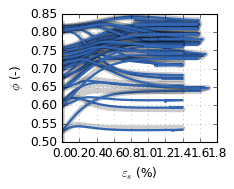

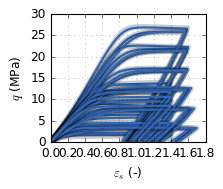

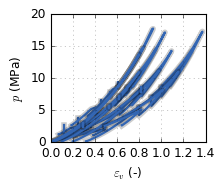

In [18]:
fig = plt.figure()
ax = fig.subplots(1)
for i in np.arange(len(ntrainval)):
    ax.plot(strain_t_tv[:,i,1],svars_tv[:,i,1].detach().numpy(),linewidth=5,color='black',alpha=0.2,markersize=0,marker='.')
    ax.plot(strain_t_tv[:,i,1],pred_svars[:,i,3].cpu().detach(),linewidth=2,color=colorb,markersize=0,marker='.')
ax.set_ylabel('$\phi$ (-)')
ax.set_xlabel('$\\varepsilon_s$ (%)')
ax.grid()
plt.show()

fig = plt.figure()
ax = fig.subplots(1)
for i in np.arange(len(ntrainval)):
    ax.plot(strain_t_tv[:,i,1],stress_tv[:,i,1].cpu().detach(),linewidth=5,color='black',alpha=0.2,markersize=0,marker='.')
    ax.plot(strain_t_tv[:,i,1],pred_stress[:,i,1].cpu().detach(),linewidth=2,color=colorb,markersize=0,marker='.')
ax.set_ylabel('$q$ (MPa)')
ax.set_xlabel('$\\varepsilon_s$ (-)')
ax.set_ylim(0,30)
ax.grid()
plt.show()

fig = plt.figure()
ax = fig.subplots(1)
for i in np.arange(len(ntrainval)):
    ax.plot(strain_t_tv[:,i,0],stress_tv[:,i,0].cpu().detach(),linewidth=5,color='black',alpha=0.2,markersize=0,marker='.')
    ax.plot(strain_t_tv[:,i,0],pred_stress[:,i,0].cpu().detach(),linewidth=2,color=colorb,markersize=0,marker='.')
ax.set_ylabel('$p$ (MPa)')
ax.set_xlabel('$\\varepsilon_v$ (-)')
ax.set_ylim(0,20)
ax.grid()
plt.show()

#### 4.4 Test set evaluation

In [19]:
svars_test.requires_grad=True

t = prm_dt*torch.linspace(0., data_size-1, (data_size)).to(device)
NICE_network.init_interp(dstrain_test,t)
sol = root(NICE_network.find_elastic_strain,
           args=([svars_test[0,:,:1].reshape(-1,1),
                 svars_test[0,:,-1:].reshape(-1,1)],
                 stress_test[0].reshape(-1,2)),
           x0=np.zeros((stress_test.shape[1],2)),
           tol=1e-12)
eps_e_0 = torch.from_numpy(sol.x.reshape(-1,2))
ueps_e_0 = NICE_network.DeNormalize(eps_e_0,NICE_network.prm_ee)
usvars = torch.cat((ueps_e_0,svars_test[0]),-1)
Ntest = np.arange(0,dstrain_test.shape[1])
pred_svars,pred_stress,pred_diss = NICE_network.integrate(dstrain_test,usvars,t,Ntest)

# Evaluate error
loss = torch.nn.L1Loss()
MAE_stress = loss(NICE_network.Normalize(pred_stress,prm_s),NICE_network.Normalize(stress_test,prm_s))
MAE_z = loss(NICE_network.Normalize(pred_svars[:,:,-1:],prm_z),NICE_network.Normalize(svars_test[:,:,-1:],prm_z))
print("MAE stress : ", MAE_stress,
      "\nMAE z : ", MAE_z)

MAE stress :  tensor(0.0058, dtype=torch.float64, grad_fn=<MeanBackward0>) 
MAE z :  tensor(0.0181, dtype=torch.float64, grad_fn=<MeanBackward0>)


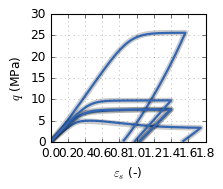

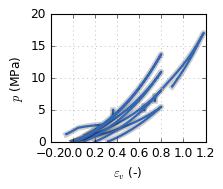

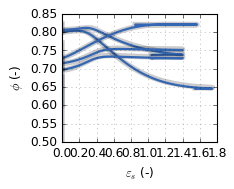

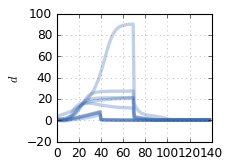

In [20]:
fig = plt.figure()
ax = fig.subplots(1)
for i in np.arange(len(ntest)):
    ax.plot(strain_t_test[:,i,1],stress_test[:,i,1].cpu().detach(),linewidth=5,color='black',alpha=0.2,markersize=0,marker='.')
    ax.plot(strain_t_test[:,i,1],pred_stress[:,i,1].cpu().detach(),linewidth=2,color=colorb,markersize=0,marker='.')
ax.set_ylabel('$q$ (MPa)')
ax.set_xlabel('$\\varepsilon_s$ (-)')
ax.grid()
ax.set_ylim(0,30)
plt.show()

fig = plt.figure()
ax = fig.subplots(1)
for i in np.arange(len(ntest)):
    ax.plot(strain_t_test[:,i,0],stress_test[:,i,0].cpu().detach(),linewidth=5,color='black',alpha=0.2,markersize=0,marker='.')
    ax.plot(strain_t_test[:,i,0],pred_stress[:,i,0].cpu().detach(),linewidth=2,color=colorb,markersize=0,marker='.')
ax.set_ylabel('$p$ (MPa)')
ax.set_xlabel('$\\varepsilon_v$ (-)')
ax.set_ylim(0,20)
ax.grid()
plt.show()

fig = plt.figure()
ax = fig.subplots(1)
for i in np.arange(len(ntest)):
    ax.plot(strain_t_test[:,i,1],svars_test[:,i,1].detach().numpy(),linewidth=5,color='black',alpha=0.2,markersize=0,marker='.')
    ax.plot(strain_t_test[:,i,1],pred_svars[:,i,3].detach().numpy(),linewidth=2,color=colorb,markersize=0,marker='.')
ax.set_ylabel('$\phi$ (-)')
ax.set_xlabel('$\\varepsilon_s$ (-)')
ax.grid()
plt.show()

fig = plt.figure()
ax = fig.subplots(1)
for i in np.arange(len(ntest)):
    ax.plot(pred_diss[:,i].cpu().detach(),linewidth=3,alpha=0.3,color=colorb,markersize=0,marker='.')
ax.set_ylabel('$d$')
ax.grid()
# ax.set_ylim(0,100)
plt.show()

### 5. Inference

In [47]:
file = './dataset/benchmark2_inference_UndrainedTriaxial_phi08'
with open(file, 'rb') as f_obj:
    data = pickle.load(f_obj)
[stress_t,strain_t,svars_e_t,epl,r_t,rs_t,stress_tdt,strain_tdt,svars_e_tdt,epl_tdt,r_tdt,rs_tdt,dt,n_reset]= data
batch_time = n_reset
data_size=n_reset

# strain protocol
dstrain = (strain_tdt - strain_t)/prm_dt

# initial condition and data for comparison
strain_t = np.reshape(strain_t,(batch_time,-1,dim),order='F')
dstrain = np.reshape(dstrain,(batch_time,-1,dim),order='F')
r_t = np.reshape(r_t,(batch_time,-1,1),order='F')
rs_t = np.reshape(rs_t,(batch_time,-1,1),order='F')
el_strain_t = np.reshape(svars_e_t,(batch_time,-1,dim),order='F')
stress_t = np.reshape(stress_t,(batch_time,-1,dim),order='F')
data_size = strain_t.shape[0]
number_IC = strain_t.shape[1]

svars = torch.cat((torch.from_numpy(np.float64(r_t)),torch.from_numpy(np.float64(rs_t))),-1).to(device)
stress = torch.from_numpy(np.float64(stress_t)).to(device)
dstrain = torch.from_numpy(np.float64(dstrain)).to(device)

In [48]:
NICE_network.inference=True
t = torch.arange(0,prm_dt*data_size,prm_dt)
initial_conditions = torch.cat((svars[0,:,:1].reshape(-1,1),svars[0,:,-1:].reshape(-1,1),stress[0].reshape(-1,2)),-1)

In [49]:
idx = np.arange(0,number_IC)
initial_conditions.requires_grad=True
NICE_network.init_interp(dstrain,t)
sol = root(NICE_network.find_elastic_strain,
           args=([initial_conditions[:,:1],initial_conditions[:,1:2]],initial_conditions[:,2:]),
           x0=np.zeros((number_IC,dim)),
           tol=1e-12)
eps_e_0 = torch.from_numpy(sol.x.reshape(-1,2))
ueps_e_0 = NICE_network.DeNormalize(eps_e_0,NICE_network.prm_ee)
usvars = torch.cat((ueps_e_0,svars[0]),-1)

pred = NICE_network.integrate(dstrain,usvars,t,idx)
pred_svars,pred_stress,pred_diss = pred
pred_svars = pred_svars.cpu().detach().numpy()
pred_stress = pred_stress.cpu().detach().numpy()
pred_diss = pred_diss.cpu().detach().numpy()

In [50]:
stress_ratio = stress_t[:,:,1]/stress_t[:,:,0]
pred_stress_ratio = pred_stress[:,:,1]/pred_stress[:,:,0]

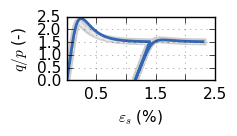

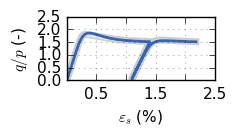

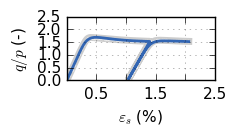

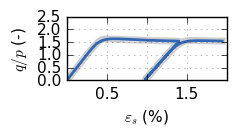

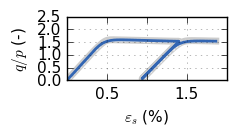

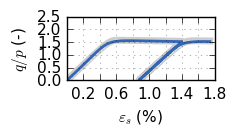

In [51]:
nid=1
for idd in range(6):
    fig = plt.figure(dpi=100, figsize=(2.5, 1.5), tight_layout=True)
    axes = fig.subplots(1)
    axes.plot(strain_t[:,idd:idd+nid,1],stress_ratio[:,idd:idd+nid],marker='o',markerfacecolor='white',linestyle='-',
        color='black',alpha=0.2,linewidth=5,markersize=0,label='ref')
    axes.plot(strain_t[::2,idd:idd+nid,1],stress_ratio[::2,idd:idd+nid],marker='o',markerfacecolor='white',markeredgewidth=0.0,linestyle='-',
        color='black',alpha=0.5,linewidth=0,markersize=2.5)
    axes.plot(strain_t[:,idd:idd+nid,1],pred_stress_ratio[:,idd:idd+nid],alpha=1,linewidth=2,color=colorb,
            markersize=0,markeredgewidth=0.0,marker='.')
    axes.set_ylabel('$q/p$ (-)')
    axes.set_xlabel('$\\varepsilon_s$ (%)')
    every_nth=2
    for n, label in enumerate(axes.xaxis.get_ticklabels()):
        if n % every_nth == 0: label.set_visible(False)
    axes.grid()    
    axes.set_ylim(0,2.5)
    plt.show()

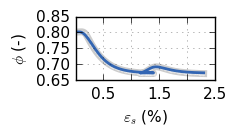

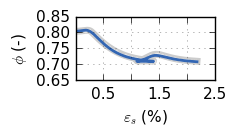

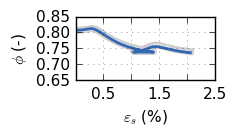

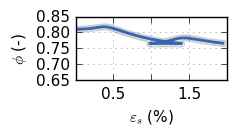

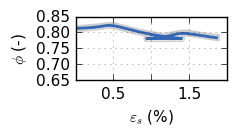

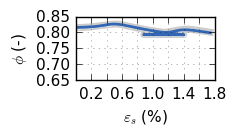

In [52]:
nid=1
for idd in range(6):
    fig = plt.figure(dpi=100, figsize=(2.5, 1.5), tight_layout=True)
    axes = fig.subplots(1)
    axes.plot(strain_t[:,idd:idd+nid,1],rs_t[:,idd:idd+nid,-1],marker='o',markerfacecolor='white',linestyle='-',
        color='black',alpha=0.2,linewidth=5,markersize=0,label='ref')
    axes.plot(strain_t[::2,idd:idd+nid,1],rs_t[::2,idd:idd+nid,-1],marker='o',markerfacecolor='white',markeredgewidth=0.0,linestyle='-',
        color='black',alpha=0.5,linewidth=0,markersize=2.5)
    axes.plot(strain_t[:,idd:idd+nid,1],pred_svars[:,idd:idd+nid,-1],alpha=1,linewidth=2,color=colorb,
            markersize=0,markeredgewidth=0.0,marker='.')
    axes.set_ylabel('$\phi$ (-)')
    axes.set_xlabel('$\\varepsilon_s$ (%)')
    axes.grid()
    every_nth=2
    for n, label in enumerate(axes.xaxis.get_ticklabels()):
        if n % every_nth == 0: label.set_visible(False)
    axes.set_ylim(0.65,0.85)
    plt.show()

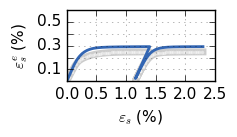

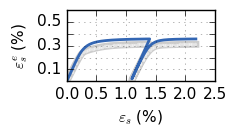

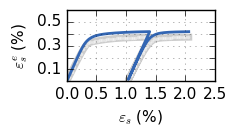

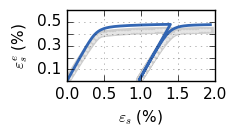

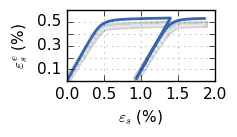

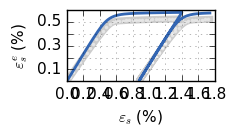

In [55]:
nid=1
for idd in range(6):
    fig = plt.figure(dpi=100, figsize=(2.5, 1.5), tight_layout=True)
    axes = fig.subplots(1)
    axes.plot(strain_t[:,idd:idd+nid,1],el_strain_t[:,idd:idd+nid,-1],marker='o',markerfacecolor='white',linestyle='-',
        color='black',alpha=0.2,linewidth=5,markersize=0,label='ref')
    axes.plot(strain_t[::2,idd:idd+nid,1],el_strain_t[::2,idd:idd+nid,-1],marker='o',markerfacecolor='white',markeredgewidth=0.0,linestyle='-',
        color='black',alpha=0.5,linewidth=0,markersize=2.5)
    axes.plot(strain_t[:,idd:idd+nid,1],pred_svars[:,idd:idd+nid,1]-pred_svars[0,idd:idd+nid,1],alpha=1,linewidth=2,color=colorb,
            markersize=0,markeredgewidth=0.0,marker='.')
    axes.set_ylabel('$\\varepsilon^e_s$ (%)')
    axes.set_xlabel('$\\varepsilon_s$ (%)')
    axes.grid()
    every_nth=2
    for n, label in enumerate(axes.yaxis.get_ticklabels()):
        if n % every_nth == 0: label.set_visible(False)
    axes.set_ylim(0,0.6)
    plt.show()

### 6. Save model

In [62]:
PATH = './saved/[state]NICE_benchmark2_sparse'
torch.save(NICE_network.state_dict(), PATH)

In [63]:
with open('./saved/[params]NICE_benchmark2_sparse', 'wb') as f_obj:
     pickle.dump(norm_params, f_obj)